#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons. 
#### For testing the concept we use 2 neurons for which we have stored the responses to a given stimulus. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))

In [3]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [4]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)

<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

In [5]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [6]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim2.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [7]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)+1]).astype(int))

Creating filters:

In [8]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [9]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

In [10]:
# Interpolate Post Spike Filter
MSP = auxfun.makeInterpMatrix(len(ht_domain),1)
MSP[0,0] = 0
H_orth = np.dot(MSP,H_orth)

(2,)
(486, 486)


Conditional Intensity (spike rate):

$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y_i + \sum_{j\ne i}I({\beta_{I}}_j)*y_j + dc)$$

$I(\beta_{I_j})$ corresponds to an interpolating filter with basis $I$ and  coefficients $\beta_{I_j}$ associated with the $y_j$ output. It is to assume that the post-spike history basis and the interpolating bases are the same: $H = I$. The intensity can then be rewritten as 

$$\lambda_{\beta}(i) = \exp\left(M_k \beta_k + \sum_{j=1}^n M_h {\beta_h}_j+\textbf{1}dc\right)$$

Creating a matrix of covariates:

<!---Simulating a neuron spike trains:-->

In [11]:
M_k = lk.construct_M_k(Stim,K,dt)

In [12]:
# creating a H-matrix for each response and merging them in one covariate matrix M_h
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))
    

#M_h_list[1] = np.zeros(M_h_list[0].shape)
M_h = np.hstack(tuple(M_h_list))

In [13]:
# combining all covariate matrices
M = np.hstack((M_k,M_h,np.ones((M_h.shape[0],1))))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

In [14]:
model = PP.PPModel(M.T,dt = dt/100)

Setting initial parameters:

In [15]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])

coeff_h0 = np.zeros((5*nofCells,))

dc0 = 3

pars0 = np.hstack((coeff_k0,coeff_h0,dc0))

In [16]:
print(pars0)
pars0 = np.array([0.15587,
    0.52019,
    1.09108,
    1.42535,
    0.83192,
    0.37496,
   -1.35405,
    0.45916,
   -0.01016,
   -0.03577,
  -15.18000,
   38.24000,
  -67.58000,
  -14.06000,
   -3.36000,
    0.00000,
    0.00000,
    0.00000,
    0.00000,
    0.00000, 3])
pars0[15:] =  np.zeros((6,))


pars0 = np.zeros((21,))
#pars0 = np.hstack((np.ones((20,)),np.ones((1,))))
print(pars0)

[ 0.061453  0.284916  0.860335  1.256983  0.910615  0.48866  -0.887091
  0.097441  0.026607 -0.090147  0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        3.      ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


Fitting the likelihood for each neuron:

In [17]:
res_list = []
for y in y_list:
    print('Initial likelihood is '+str(model.negLogL(pars0,y)))
    res_list.append(model.fit(y,start_coef = pars0, maxiter = 500, method = 'L-BFGS-B'))

25.0
Initial likelihood is 25.0
25.0
-2373.00563403
-2653.92086857
-2590.11509921
-2792.01243916
-2945.95017003
-3065.69041638
-3143.08712395
-3219.70729097
-3263.73395283
-3383.76534942
-3438.70225974
-3491.77714663
-3531.78628264
-3600.0231482
-3667.63558198
-3618.53807814
-3692.20075822
-3718.184831
-3740.34870711
-3746.12110661
-3749.01798164
-3752.00444697
-3758.41348685
-3772.47086905
-3798.67740566
-3839.58764274
-3883.56469404
-3928.16203083
-3979.89291786
-4074.49264438
-4244.57383985
-4536.64177959
-4663.81651049
-4874.38179401
-4920.23517649
-4941.95209738
-4958.86602001
-4965.34525525
-4968.02586041
-4968.87386213
-4969.37255443
-4969.91999967
-4970.59727022
-4971.7258474
-4973.37999927
-4975.77461528
-4977.46133111
-4982.16244209
-4985.60933573
-4989.01554112
-4995.12700858
-5006.04626527
-4927.86841136
-5010.65109573
-5026.28216477
-5040.37478642
-5052.24856876
-5059.9852565
-5062.01813216
-5065.7640983
-5067.379629
-5070.16942417
-5074.9530221
-5080.93110135
-5086.591041

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:171: OptimizeWarning: Unknown solver options: maxfev
  res = optimize.minimize(self.negLogL,start_coef,jac = self.gradNegLogL,hess = self.hessNegLogL, args = y, options = opts, method = method)


In [18]:
[print('\n Optimization results:\n'+str(res)) for res in res_list]


 Optimization results:
       x: array([  5.13824038e-02,   2.82712959e-01,   8.43214908e-01,
         1.20712875e+00,   9.33004017e-01,   5.04131619e-01,
        -9.15673292e-01,   1.41984213e-01,  -3.36716503e-03,
        -6.68070198e-02,  -1.51408914e+01,   3.89451066e+01,
        -6.75304761e+01,  -1.36291294e+01,  -4.66911403e+00,
        -1.33811029e-01,  -7.35490093e-01,   1.47097688e+00,
        -9.19007644e-01,   7.46556190e-01,   3.04875795e+00])
    nfev: 542
     fun: -5252.9766899764727
     jac: array([ 0.32796353, -0.81771162, -1.17829772,  0.14903547, -1.43539642,
        0.45543686,  0.38345457, -2.1846063 , -4.37447712, -0.72562013,
       -0.09158658,  0.15053873,  0.09126471,  0.02359388,  0.15416549,
       -0.03900187, -0.08243471,  0.17292723, -0.25657332, -0.30810721,
       -2.16429064])
  status: 1
 success: False
     nit: 501
 message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'

 Optimization results:
       x: array([  7.05663468e-02,   3.09214315e-01,

[None, None]

In [19]:
k_coeff = np.array([0.061453, 0.284916, 0.860335, 1.256983, 0.910615, 0.488660, -0.887091, 0.097441, 0.026607, -0.090147])
h_coeff = np.array([-15.18,38.24,-67.58,-14.06,-3.36])

Estimated dc for neuron 0: 3.04875795424
Estimated dc for neuron 1: 3.12273698411


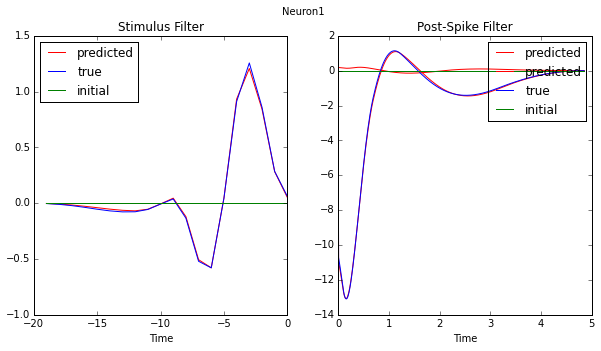

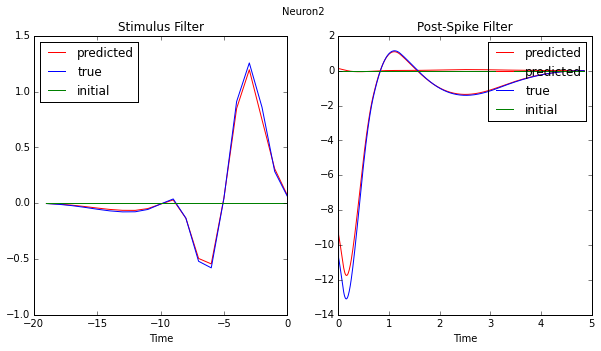

In [20]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = np.reshape(res_list[i].x[10:-1],(H.shape[1],nofCells),order = 'F')
    print('Estimated dc for neuron '+str(i)+': '+str(res_list[i].x[-1]))
    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted),'r',label = 'predicted')
    axs[0].set_title('Stimulus Filter')
    axs[0].hold(True)
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff),'b',label = 'true')
    axs[0].plot(-kt_domain[::-1],np.dot(K,pars0[:10]),'g',label = 'initial')
    axs[0].set_xlabel('Time')
    axs[0].legend(loc = 'upper left')
    axs[1].plot(ht_domain,np.dot(H_orth,h_coeff_predicted),'r',label = 'predicted')
    axs[1].plot(ht_domain,np.dot(H_orth,h_coeff),'b',label = 'true')
    axs[1].plot(ht_domain,np.dot(H_orth,coeff_h0[:H_orth.shape[1]]),'g',label = 'initial')
    axs[1].set_title('Post-Spike Filter')
    axs[1].set_xlabel('Time')
    axs[1].legend(loc = 'upper right')
  